In [3]:
import pandas as pd
from access_onedrive import create_onedrive_directdownload
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
onedrive_link = 'https://1drv.ms/x/s!AsCp_kE1E5Md6U4PwNcWkXp_SnEL?e=3gStJc'
link = create_onedrive_directdownload(onedrive_link)
df = pd.read_excel(link)

In [5]:
df.head(5)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388797 entries, 0 to 388796
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       388797 non-null  int64 
 1   ER_No            388797 non-null  object
 2   Triage_Datetime  388797 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.9+ MB


In [6]:
#removing anomalies
df = df[df.Triage_Datetime != df.ER_No]
df.pop(df.columns[0])

0              0
1              1
2              2
3              3
4              4
           ...  
388792    388792
388793    388793
388794    388794
388795    388795
388796    388796
Name: Unnamed: 0, Length: 384095, dtype: int64

In [7]:
#fetching date from the datetime column
df['Triage_Datetime'] = pd.to_datetime(df['Triage_Datetime'])
df['Triage_Datetime'] = df['Triage_Datetime'].dt.date
df.head(5)

,ER_No,Triage_Datetime
0,E001467306,2019-04-30
1,E001461259,2019-04-19
2,E001453586,2019-04-05
3,E001455608,2019-04-09
4,E001467427,2019-04-30


In [8]:
new_df = df.groupby(['Triage_Datetime'])['Triage_Datetime'].count().reset_index(name='Count of Patients')
# new_df.index = new_df['Triage_Datetime']
# del new_df['Triage_Datetime']
new_df.head(5)
# new_df.info()


,Triage_Datetime,Count of Patients
0,2019-01-01,348
1,2019-01-02,371
2,2019-01-03,373
3,2019-01-04,361
4,2019-01-05,373


<AxesSubplot: xlabel='Triage_Datetime', ylabel='Count of Patients'>

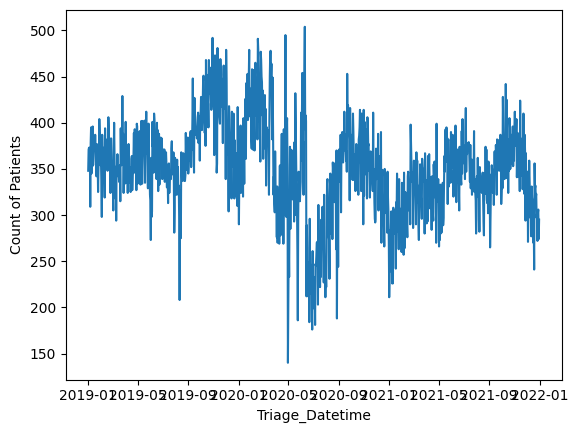

In [9]:
sns.lineplot(x = 'Triage_Datetime', y = 'Count of Patients', data = new_df)

In [10]:
#making date column the index
# new_df['Date'] = new_df.index
# del new_df['Triage_Datetime']

In [15]:

# x-label = date; y-label = count
new_df['Triage_Datetime'] = pd.to_datetime(new_df['Triage_Datetime'])
train = new_df[new_df['Triage_Datetime'] < pd.to_datetime("2021-09", format='%Y-%m')]
test = new_df[new_df['Triage_Datetime'] >= pd.to_datetime("2021-09", format='%Y-%m')]
train.head(5)
# train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Triage_Datetime    974 non-null    datetime64[ns]
 1   Count of Patients  974 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.8 KB


<AxesSubplot: xlabel='Triage_Datetime', ylabel='Count of Patients'>

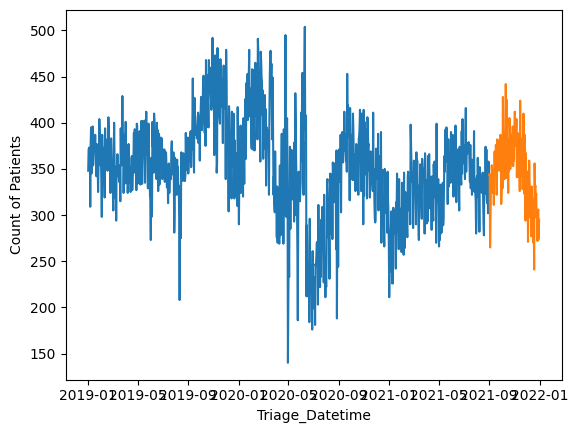

In [12]:
sns.lineplot(x = 'Triage_Datetime', y = 'Count of Patients', data = train)
sns.lineplot(x = 'Triage_Datetime', y = 'Count of Patients', data = test)

MODELLING

In [22]:
train.index = train['Triage_Datetime']
del train['Triage_Datetime']
train.head()



KeyError: 'Triage_Datetime'

In [24]:
test.index = test['Triage_Datetime']
del test['Triage_Datetime']
test.head()

,Count of Patients
Triage_Datetime,
2021-09-01,344
2021-09-02,344
2021-09-03,265
2021-09-04,294
2021-09-05,328


In [26]:
# from pmdarima.arima import auto_arima
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9725.365, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10105.611, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9861.460, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9728.050, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10103.611, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9722.285, Time=2.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9728.488, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9728.126, Time=0.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9722.689, Time=1.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9725.915, Time=1.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9724.503, Time=1.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.49 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 17.523 seconds


ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

In [27]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

<AxesSubplot: xlabel='Triage_Datetime'>

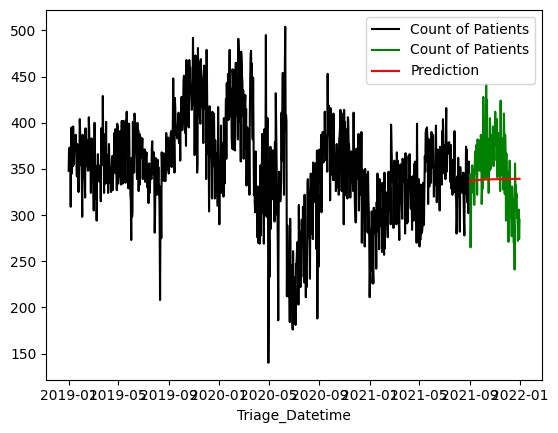

In [35]:
sns.lineplot(data = train, palette = ['black'])
sns.lineplot(data = test, palette = ['green'])
sns.lineplot(data = forecast, palette = ['red'])

In [37]:
from statsmodels.tsa.arima.model import ARIMA


In [41]:
y = train['Count of Patients']
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Hp\AppData\Local\

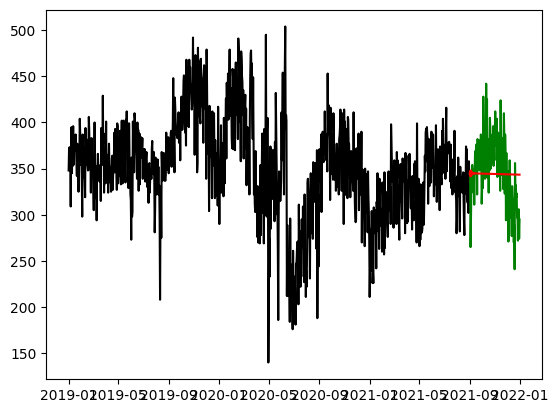

In [45]:
plt.plot(train, color='Black')
plt.plot(test, color='Green')
plt.plot(y_pred_out, color='Red', label = 'ARIMA Predictions')